## Hybrid method: Recursive feature addition

This method consists of the following steps:

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or coefficients from linear models.

2) Build a machine learning model with only 1 feature, the most important one, and calculate the model metric for performance.

3) Add one feature -the most important- and build a machine learning algorithm utilising the added and any feature from previous rounds.

4) Calculate a performance metric of your choice: roc-auc, mse, rmse, accuracy, etc.

5) If the metric increases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

6) Repeat steps 2-5 until all features have been evaluated.


I call this a hybrid method because:

- it derives the importance derived from the machine learning algorithm, like embedded methods
- it builds several machine learning models, like wrapper methods.

This method is faster than wrapper methods and often better than embedded methods. In practice it works extremely well. 

One thing to note is that the minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop the more features will be selected, and vice versa.

I will demonstrate how to select features using this method on a regression and classification problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import train_test_split

## Classification

In [2]:
# load dataset
data = pd.read_csv('../dataset_1.csv')
data.shape

(50000, 301)

In [3]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300,target
0,0,0,0.0,0.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
1,0,0,0.0,3.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
2,0,0,0.0,5.88,0.0,0,0,0,0,0,...,0.0,0,0,3,0,0,0,0.0,67772.7216,0
3,0,0,0.0,14.10,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
4,0,0,0.0,5.76,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0


**Important**

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [4]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 300), (15000, 300))

### Remove constant and quasi-constant features

In [5]:
# to speed things up we remove constant, quasi-constand and duplicated features

quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = X_train[feature].value_counts(
        normalize=True).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 158), (15000, 158))

### Remove duplicated

In [6]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


6

In [7]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 152), (15000, 152))

### Train a ML model with all features

In [8]:
# the first step of this procedure consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# build initial model using all the features
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

model_full.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f' % (roc_full))

Test ROC AUC=0.827532


### Rank features by importance

Text(0.5, 0, 'Feature')

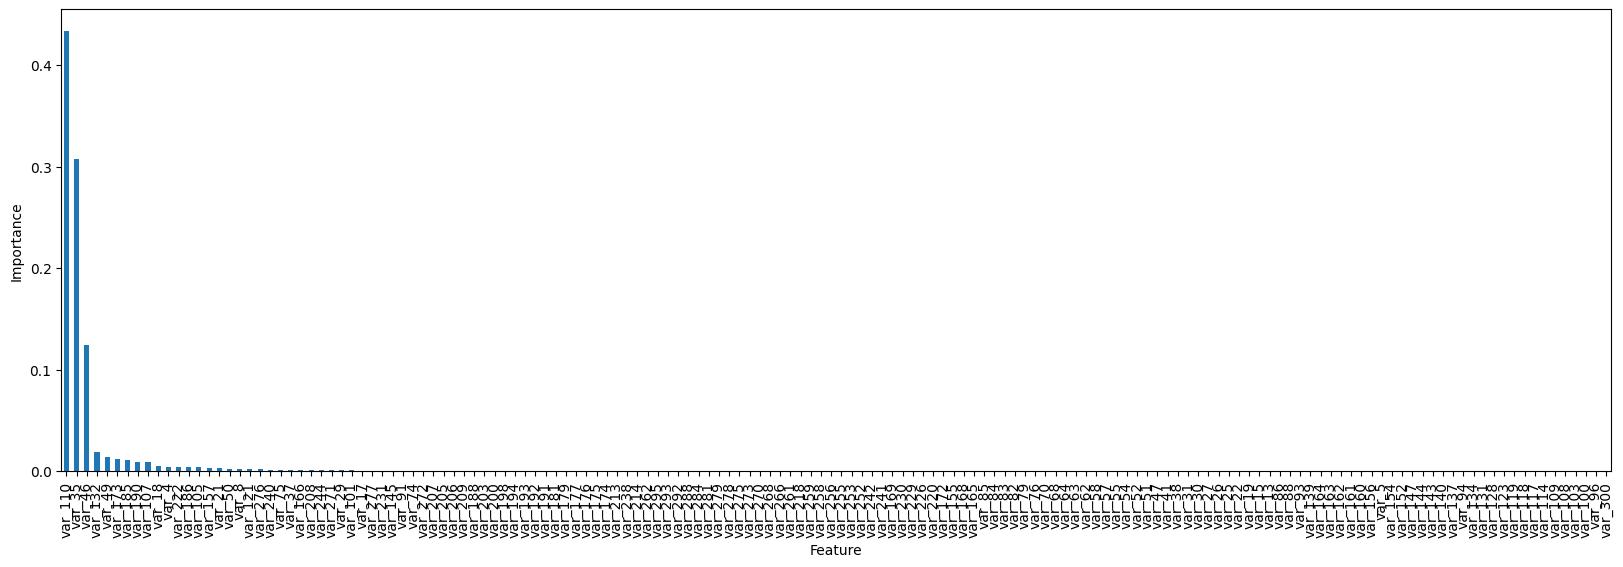

In [9]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.ylabel('Importance')
plt.xlabel('Feature')

In [10]:
# make list of ordered features
features = list(features.index)
features

['var_110',
 'var_35',
 'var_46',
 'var_132',
 'var_49',
 'var_173',
 'var_185',
 'var_190',
 'var_107',
 'var_18',
 'var_4',
 'var_222',
 'var_186',
 'var_105',
 'var_157',
 'var_21',
 'var_50',
 'var_8',
 'var_121',
 'var_276',
 'var_240',
 'var_75',
 'var_37',
 'var_166',
 'var_208',
 'var_244',
 'var_271',
 'var_29',
 'var_101',
 'var_17',
 'var_277',
 'var_231',
 'var_145',
 'var_91',
 'var_74',
 'var_272',
 'var_207',
 'var_205',
 'var_206',
 'var_209',
 'var_188',
 'var_203',
 'var_200',
 'var_198',
 'var_194',
 'var_193',
 'var_192',
 'var_191',
 'var_181',
 'var_179',
 'var_177',
 'var_176',
 'var_175',
 'var_174',
 'var_213',
 'var_238',
 'var_214',
 'var_262',
 'var_295',
 'var_293',
 'var_292',
 'var_288',
 'var_284',
 'var_281',
 'var_279',
 'var_278',
 'var_275',
 'var_273',
 'var_270',
 'var_268',
 'var_266',
 'var_261',
 'var_218',
 'var_259',
 'var_258',
 'var_256',
 'var_255',
 'var_253',
 'var_252',
 'var_242',
 'var_241',
 'var_169',
 'var_230',
 'var_229',
 'var_22

### Build a ML model with 1 feature

In [11]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# build initial model using all the features
model_one_feature = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]

roc_first = roc_auc_score(y_test, y_pred_test)

print('Test one feature xgb ROC AUC=%f' % (roc_first))

Test one feature xgb ROC AUC=0.700436


### Select features

In [12]:
# the final step consists in adding one feature at a time
# from the most to the least important, building a model
# and determining its performance

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is bigger than the original one
# (with one feature), then that feature that was added
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature addition:

# first we arbitrarily set the increase in roc-auc
# if the increase is above this threshold,
# the feature will be kept
tol = 0.0001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know which feature is being evaluated
count = 1

# now we loop over all the features, in order of importance:
# remember that features in the list are ordered
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # print the original roc-auc with one feature
    print('Previous round Test ROC AUC={}'.format((roc_first)))

    # determine the increase in the roc-auc
    diff_roc = roc_int - roc_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        roc_first = roc_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  var_35 1  out of  152
New Test ROC AUC=0.8126631456095583
Previous round Test ROC AUC=0.7004355259402437
Increase in ROC AUC=0.1122276196693146
keep:  var_35

testing feature:  var_46 2  out of  152
New Test ROC AUC=0.8179917540572695
Previous round Test ROC AUC=0.8126631456095583
Increase in ROC AUC=0.005328608447711214
keep:  var_46

testing feature:  var_132 3  out of  152
New Test ROC AUC=0.819437196040365
Previous round Test ROC AUC=0.8179917540572695
Increase in ROC AUC=0.0014454419830954857
keep:  var_132

testing feature:  var_49 4  out of  152
New Test ROC AUC=0.8196620237318119
Previous round Test ROC AUC=0.819437196040365
Increase in ROC AUC=0.00022482769144682724
keep:  var_49

testing feature:  var_173 5  out of  152
New Test ROC AUC=0.823239485575252
Previous round Test ROC AUC=0.8196620237318119
Increase in ROC AUC=0.0035774618434400995
keep:  var_173

testing feature:  var_185 6  out of  152
New Test ROC AUC=0.82179901

In [13]:
# finally, let's compare performance of a model built using the selected
# features vs the full model

# build initial model
model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=0.829743


As you can see, the Gradient Boosting model built with 16 features shows a similar performance than the one built the full dataset (you need to scroll up to find this value, we calculated a few cells ago).

**Exercise**
Why don't you go ahead and try different values of tolerance? Try with lower and bigger thresholds and get a feeling of how much this affects the number of selected features.

## Regression

In [14]:
# load dataset
data = pd.read_csv('../houseprice.csv')
data.shape

(1460, 81)

In [15]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [16]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id','SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [17]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

### Rank features by importance

In [18]:
# the first step of this procedure consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# build initial model using all the features
model_full = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

model_full.fit(X_train, y_train)

# calculate r2 in the test set
y_pred_test = model_full.predict(X_test)
r2_full = r2_score(y_test, y_pred_test)

print('Test full dataset R2 = %f' % (r2_full))

Test full dataset R2 = 0.713130


<Axes: >

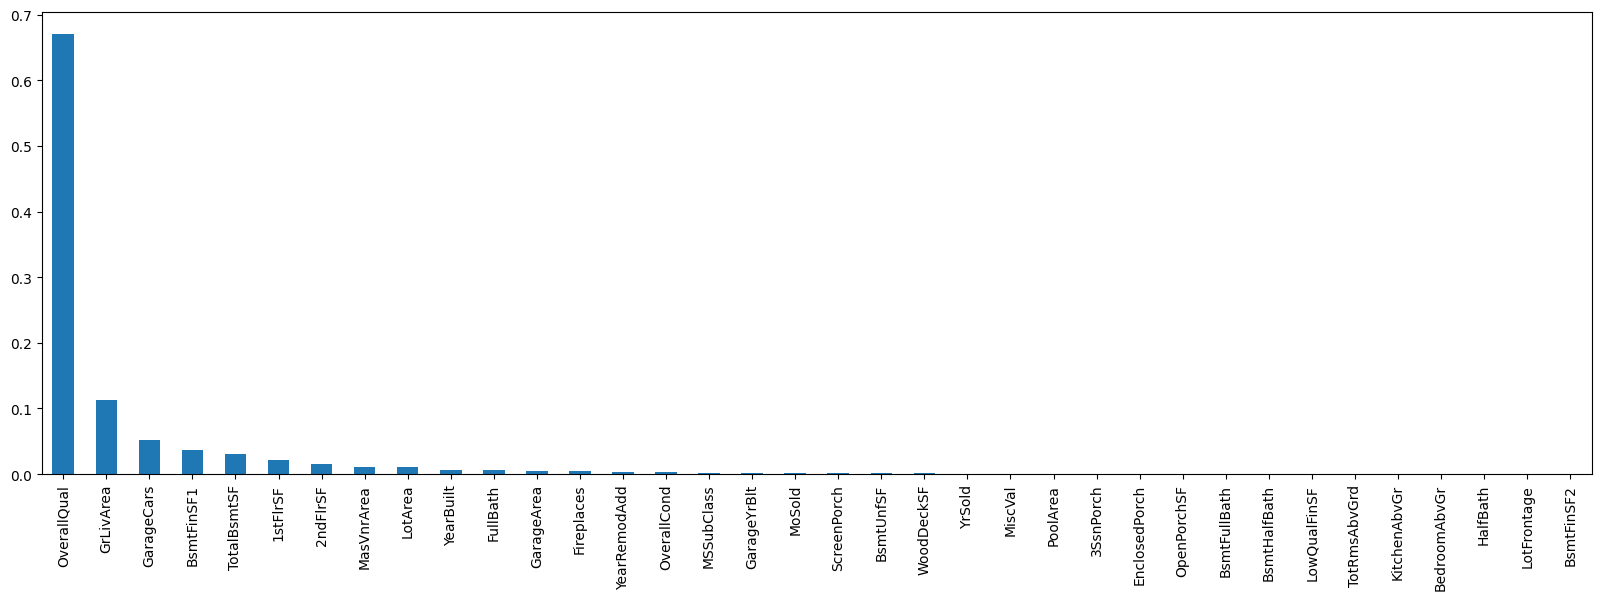

In [19]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [20]:
# make list of ordered features
features = list(features.index)
features

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'MasVnrArea',
 'LotArea',
 'YearBuilt',
 'FullBath',
 'GarageArea',
 'Fireplaces',
 'YearRemodAdd',
 'OverallCond',
 'MSSubClass',
 'GarageYrBlt',
 'MoSold',
 'ScreenPorch',
 'BsmtUnfSF',
 'WoodDeckSF',
 'YrSold',
 'MiscVal',
 'PoolArea',
 '3SsnPorch',
 'EnclosedPorch',
 'OpenPorchSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'LowQualFinSF',
 'TotRmsAbvGrd',
 'KitchenAbvGr',
 'BedroomAbvGr',
 'HalfBath',
 'LotFrontage',
 'BsmtFinSF2']

### Build ML model with 1 feature

In [21]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# build initial model with 1 feature
model_one_feature = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the r2 in the test set
y_pred_test = model_one_feature.predict(X_test[features[0]].to_frame())
r2_first = r2_score(y_test, y_pred_test)
print('Test one feature R2=%f' % (r2_first))

Test one feature R2=0.631051


### Select features

In [22]:
# the final step consists in adding one feature at a time
# from the most to the least important one,
# and build a model and evaluate its performance.

# once we build the model, we calculate the new r2
# if the new r2 is bigger than the original one
# (with one feature), then that feature that was added
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature addition:

# first we arbitrarily set the increase in r2
# if the increase is above this threshold,
# the feature will be kept
tol = 0.001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict(X_test[features_to_keep + [feature] ])

    # calculate the new r2
    r2_int = r2_score(y_test, y_pred_test)
    print('New Test R2={}'.format((r2_int)))

    # print the original roc-auc with all the features
    print('Previous round R2={}'.format((r2_first)))

    # determine the drop in the roc-auc
    diff_r2 = r2_int - r2_first

    # compare the increase in r2 with the tolerance
    # we set previously
    if diff_r2 >= tol:
        print('Increase in r2 = {}'.format(diff_r2))
        print('keep: ', feature)
        print
        # if the increase in the r2 is bigger than the threshold
        # we keep the feature and re-adjust the r2 to the new value
        # considering the added feature
        r2_first = r2_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in r2 = {}'.format(diff_r2))
        print('remove: ', feature)
        print


# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  GrLivArea 1  out of  36
New Test R2=0.7059734876125235
Previous round R2=0.6310512609331753
Increase in r2 = 0.07492222667934822
keep:  GrLivArea

testing feature:  GarageCars 2  out of  36
New Test R2=0.7163472150540834
Previous round R2=0.7059734876125235
Increase in r2 = 0.010373727441559843
keep:  GarageCars

testing feature:  BsmtFinSF1 3  out of  36
New Test R2=0.7123499142207127
Previous round R2=0.7163472150540834
Increase in r2 = -0.003997300833370687
remove:  BsmtFinSF1

testing feature:  TotalBsmtSF 4  out of  36
New Test R2=0.7340937364428985
Previous round R2=0.7163472150540834
Increase in r2 = 0.017746521388815162
keep:  TotalBsmtSF

testing feature:  1stFlrSF 5  out of  36
New Test R2=0.7373851754622972
Previous round R2=0.7340937364428985
Increase in r2 = 0.0032914390193986565
keep:  1stFlrSF

testing feature:  2ndFlrSF 6  out of  36
New Test R2=0.7453233235301489
Previous round R2=0.7373851754622972
Increase in r2 = 0

In [23]:
# finally let's test the performance of the model 
# built on the selected features

# build initial model
model_final = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict(X_test[features_to_keep])

# calculate roc-auc
r2_final = r2_score(y_test, y_pred_test)
print('Test selected features r2 = %f' % (r2_final))

Test selected features r2 = 0.745323


The model built with 6 features shows better performance! (you need to scroll up to find this value, we calculated a few cells ago).

Go ahead and try different tol values to examine the sensitivity of this algorithm.

That is all for this lecture, I hope you enjoyed it and see you in the next one!